In [1]:
import sys
sys.path.append("C:/Users/win7/Desktop/natural-language-processing-master/natural-language-processing-master")
from common1.download_utils import download_week1_resources
download_week1_resources()

File data\train.tsv is already downloaded.
File data\validation.tsv is already downloaded.
File data\test.tsv is already downloaded.
File data\text_prepare_tests.tsv is already downloaded.


In [2]:
from week1.grader import Grader
grader = Grader()

In [3]:
#Text Preprocessing

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\win7\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
from ast import literal_eval
import pandas as pd
import numpy as np

In [5]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

In [6]:
train = read_data('data/train.tsv')
validation = read_data('data/validation.tsv')
test = pd.read_csv('data/test.tsv',sep='\t')

In [7]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

In [8]:
import re

In [9]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()# lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)# delete stopwors from text
    return text

In [10]:
def test_text_prepare():
    examples = ["SQL Server - any equivalent of Excel's CHOOSE function?","How to free c++ memory vector<int> * arr?"]
    answers = ["sql server equivalent excels choose function","free c++ memory vectorint arr"]
    for ex, ans in zip(examples, answers):
        if text_prepare(ex) != ans:
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [11]:
print(test_text_prepare())

Basic tests are passed.


In [12]:
prepared_questions = []
for line in open('data/text_prepare_tests.tsv', encoding='utf-8'):
    line = text_prepare(line.strip())
    prepared_questions.append(line)
text_prepare_results = '\n'.join(prepared_questions)

grader.submit_tag('TextPrepare', text_prepare_results)

Current answer for task TextPrepare is:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...


In [13]:
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

In [14]:
# Dictionary of all tags from train corpus with their counts.
#tags_counts = {}
# Dictionary of all words from train corpus with their counts.
#words_counts = {}


from collections import defaultdict

tags_counts = defaultdict(int)
words_counts = defaultdict(int)

for tags in y_train:
    for tag in tags:
        tags_counts[tag] += 1
for text in X_train:
    for word in text.split():
        words_counts[word] += 1
#words=[]
#tag_w=[]
#l=len(X_train)
#for i in range(0,l):
    #words = words+(re.findall(r'\w+', X_train[i]))
    #tag_w = tag_w+y_train[i] 
#words_counts = Counter(words)
#tags_counts=Counter(tag_w)

In [15]:
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]

grader.submit_tag('WordsTagsCount', '%s\n%s' % (','.join(tag for tag, _ in most_common_tags), 
                                                ','.join(word for word, _ in most_common_words)))

Current answer for task WordsTagsCount is:
 javascript,c#,java
using,php,java...


In [16]:
DICT_SIZE = 5000
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:5000] 
WORDS_TO_INDEX={}
INDEX_TO_WORDS={}
for i in range(0,5000):
    current_word = most_common_words[i][0]
    WORDS_TO_INDEX[current_word]=i  
    INDEX_TO_WORDS[i]=current_word 

ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, dict_size):
    result_vector = np.zeros(dict_size)
    text_words=text.split(" ")
    for i in range(0,len(text_words)):
        for key,value in words_to_index.items():
            if text_words[i]==key:
                if result_vector[words_to_index[key]]==0:
                    result_vector[words_to_index[key]]=result_vector[words_to_index[key]]+1
    return result_vector

In [17]:
def test_my_bag_of_words():
    words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
    examples = ['hi how are you hi']
    answers = [[1, 1, 0, 1]]
    for ex, ans in zip(examples, answers):
        if (my_bag_of_words(ex, words_to_index, 4) != ans).any():
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [18]:
print(test_my_bag_of_words())

Basic tests are passed.


In [19]:
from scipy import sparse as sp_sparse

In [20]:
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (100000, 5000)
X_val shape  (30000, 5000)
X_test shape  (20000, 5000)


In [21]:
row = X_train_mybag[10].toarray()[0]
non_zero_elements_count=0
for i in range(0,DICT_SIZE):
    if (row[i]!=0):
        print(row[i])
        non_zero_elements_count=non_zero_elements_count+1

1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [22]:
print(non_zero_elements_count)

7


In [23]:
grader.submit_tag('BagOfWords', str(non_zero_elements_count))

Current answer for task BagOfWords is:
 7...


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [25]:
def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    tfidf_vectorizer =  TfidfVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),token_pattern= '(\S+)')
    X_train=tfidf_vectorizer.fit_transform(X_train)
    X_val=tfidf_vectorizer.transform(X_val)
    X_test=tfidf_vectorizer.transform(X_test)
    
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

In [26]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [27]:
for word in tfidf_vocab.keys():
    if word== 'c++':
        print(tfidf_vocab[word])

1976


In [28]:
#MultiLabel classifier
from sklearn.preprocessing import MultiLabelBinarizer

In [29]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

In [30]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [52]:
from sklearn.svm import SVC
def train_classifier(X_train, y_train):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    
    # Create and fit LogisticRegression wraped into OneVsRestClassifier.
    return OneVsRestClassifier(RidgeClassifier(normalize=True)).fit(X_train,y_train)

In [53]:
classifier_mybag = train_classifier(X_train_mybag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

In [54]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

In [55]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(3):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	c#,class


Title:	contenttype application json required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	json,ruby,ruby-on-rails,ruby-on-rails-3




In [31]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [32]:
def print_evaluation_scores(y_val, predicted):
    accuracy=accuracy_score(y_val, predicted)
    f1_score_macro=f1_score(y_val, predicted, average='macro')
    f1_score_micro=f1_score(y_val, predicted, average='micro')
    f1_score_weighted=f1_score(y_val, predicted, average='weighted')
    precision_macro=average_precision_score(y_val, predicted, average='macro')
    precision_micro=average_precision_score(y_val, predicted, average='micro')
    precision_weighted=average_precision_score(y_val, predicted, average='weighted')
    print(accuracy,f1_score_macro,f1_score_micro,f1_score_weighted,precision_macro,precision_micro,precision_weighted)

In [59]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words
0.025933333333333333 0.34285758481541145 0.4026063958484552 0.4920666220588761 0.19110306336436542 0.22304977656826117 0.33026198825735775
Tfidf
0.225 0.5596969529853179 0.639629945149382 0.6577275000282193 0.36635871538815734 0.42091413680340645 0.4839732921973651


In [49]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words
0.3424 0.4994013438869196 0.6574535426655385 0.6341730524582876 0.3390868599317076 0.463741666896236 0.49426117443620277
Tfidf
0.33363333333333334 0.4442030131093959 0.6403418428837515 0.6128137266508615 0.3007538166371564 0.45526079280229065 0.48358673078825803


In [33]:
from week1.metrics import roc_auc
%matplotlib inline

In [34]:
from sklearn.svm import SVC
from sklearn import svm
def train_classifier(X_train, y_train):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    
    # Create and fit LogisticRegression wraped into OneVsRestClassifier.
    return OneVsRestClassifier(LogisticRegression(penalty="l1",C=1)).fit(X_train,y_train)

# OneVsRestClassifier(svm.LinearSVC(random_state=random_state))
     #OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 #random_state=random_state))

In [35]:
classifier_mybag = train_classifier(X_train_mybag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

In [36]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

In [37]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(3):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	


Title:	contenttype application json required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	json,ruby-on-rails




In [38]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words
0.3680333333333333 0.519124574088714 0.6801855070079283 0.6581647583040987 0.35802186498596933 0.49108320319000226 0.5204495704003087
Tfidf
0.36546666666666666 0.5087341792204046 0.675123781727211 0.652465556577037 0.3493177617917214 0.48763539427444863 0.5170915273975945


In [40]:
test_predictions = classifier_mybag.predict(X_test_mybag)
test_pred_inversed = mlb.inverse_transform(test_predictions)

test_predictions_for_submission = '\n'.join('%i\t%s' % (i, ','.join(row)) for i, row in enumerate(test_pred_inversed))
grader.submit_tag('MultilabelClassification', test_predictions_for_submission)

Current answer for task MultilabelClassification is:
 0	mysql,php
1	javascript
2	
3	javascript,jquery
4	android,java
5	php,xml
6	json,web-services
7	java,...


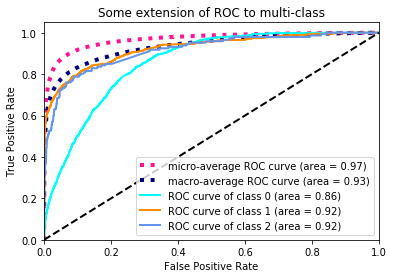

In [41]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)

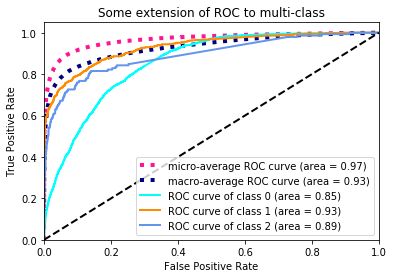

In [42]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)

In [43]:
grader.status()

You want to submit these parts:
Task TextPrepare:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...
Task WordsTagsCount:
 javascript,c#,java
using,php,java...
Task BagOfWords:
 7...
Task MultilabelClassification:
 0	mysql,php
1	javascript
2	
3	javascript,jquery
4	android,java
5	php,xml
6	json,web-services
7	java,...


In [44]:
STUDENT_EMAIL = "mail2gaurav1998@gmail.com" 
STUDENT_TOKEN = "Jj21obaZhEQSS6IU"
grader.status()

You want to submit these parts:
Task TextPrepare:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...
Task WordsTagsCount:
 javascript,c#,java
using,php,java...
Task BagOfWords:
 7...
Task MultilabelClassification:
 0	mysql,php
1	javascript
2	
3	javascript,jquery
4	android,java
5	php,xml
6	json,web-services
7	java,...


In [45]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)

Submitted to Coursera platform. See results on assignment page!
